## IS620 - Project 2 - Two-Node Networks
### Brian Chu | Oct 11, 2015

### (1) Identify a large 2-node network dataset—you can start with a dataset in a repository.  Your data should meet the criteria that it consists of ties between and not within two (or more) distinct groups.

I found a malaria dataset with nodes as genes and substrings.  
  
**Source**: http://danlarremore.com/bipartiteSBM/malariaData.zip  
**Citation**: Larremore, D. B., Clauset, A., and Buckee, C. O. (2013). A Network Approach to Analyzing Highly Recombinant Malaria Parasite Genes. PLoS Computational Biology, 9(10), e1003268.

### (2) Reduce the size of the network using a method such as the island method described in chapter 4 of social network analysis.

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

**Let's first examine the original data and resulting network graph**

In [2]:
G = nx.Graph()
G = nx.read_weighted_edgelist("malaria.edgelist", delimiter="\t", comments="%")

In [3]:
len(nx.nodes(G))

1103

In [4]:
nx.number_of_edges(G)

2965

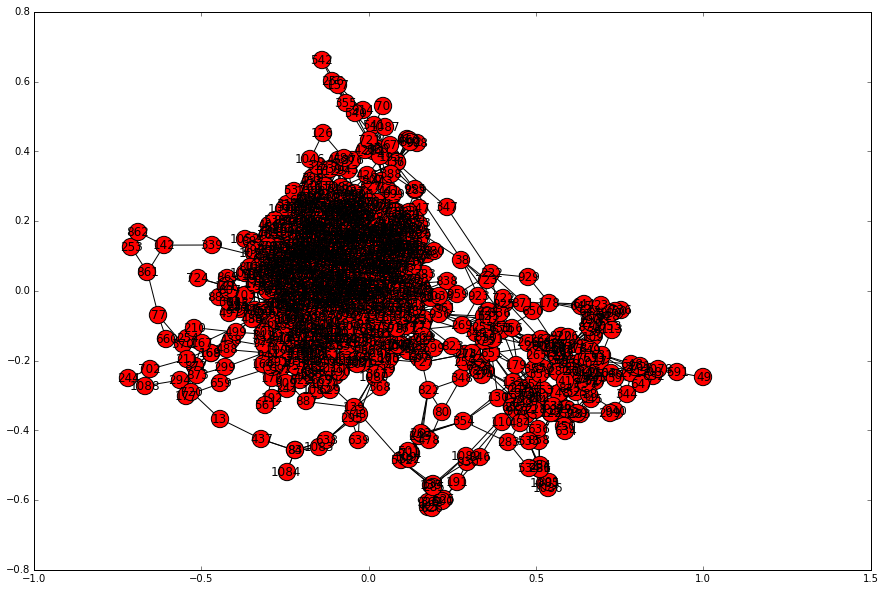

In [5]:
plt.figure(figsize=(15,10))
nx.draw_networkx(G)
plt.show()

**As expected, this is rather messy to look at but there does appear to be one large cluster and at least one other sizable one. Let's project this bipartite graph onto just the gene nodes and graph the results.**

In [6]:
# Grab list of gene nodes for projection
import csv
glist = []
with open('genes.csv', 'rb') as f:
    reader = csv.reader(f, delimiter=',')
    for row in reader:
        glist.append(row)
glist = [item for sublist in glist for item in sublist]

In [7]:
# Use NetworkX projection function for bipartite data
from networkx.algorithms import bipartite as bi
B = bi.weighted_projected_graph(G, glist, ratio=False)
weights = [edata['weight'] for f,t,edata in B.edges(data=True)]

In [8]:
len(nx.nodes(B))

297

In [9]:
nx.number_of_edges(B)

3010

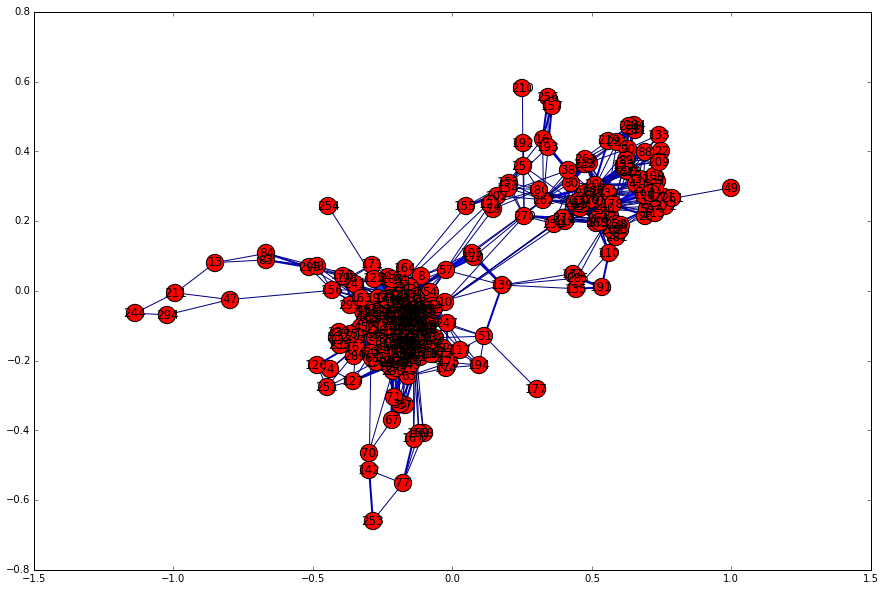

In [10]:
plt.figure(figsize = (15,10))
nx.draw_networkx(B, width=weights, edge_color=weights)

**This is a little better. We still see the one larger cluster and two smaller ones. Let's try reducing the network by using the island method to trim edges. Edge weight in this network is the number of common substrings between gene nodes.**

In [11]:
# Borrowed from SNAS pg 62-64
def trim_edges(g, weight=1): 
    g2=nx.Graph()
    for f, to, edata in g.edges(data=True): 
        if edata['weight'] > weight:
            g2.add_edge(f,to,edata)
    return g2

In [12]:
# Borrowed from SNAS pg 62-64
def island_method(g, iterations=5):
    weights = [edata['weight'] for f,to,edata in g.edges(data=True)]
    mn = int(min(weights))
    mx = int(max(weights))
    step = int((mx-mn)/iterations)
    return [[threshold, trim_edges(g, threshold)] for threshold in range(mn,mx,step)]

In [13]:
islands = island_method(B)
for i in islands:
    print i[0], len(i[1])

1 279
5 135
9 61
13 23
17 8
21 2


**The results show that the network shrinks dramatically even when genes with single common substrings are dropped. Let's trim edges up to 13 connections, which leaves us with a more manageable 23 nodes.**

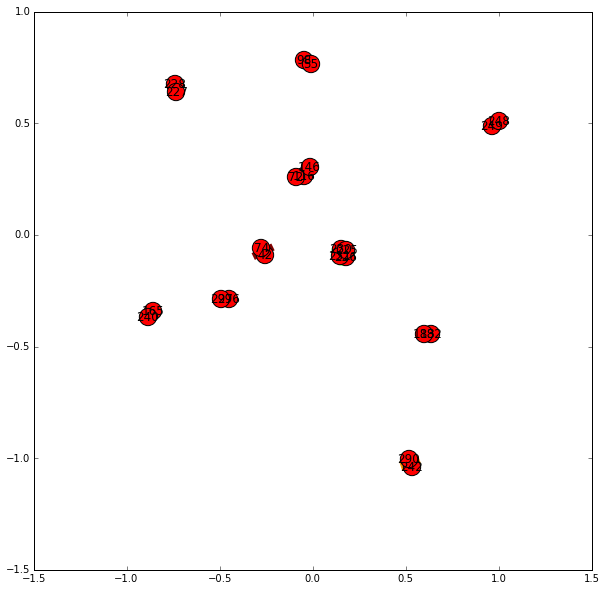

In [14]:
B2 = trim_edges(B, 13)
plt.figure(figsize = (10,10))
weights = [edata['weight'] for f,t,edata in B2.edges(data=True)]
nx.draw_networkx(B2, width=weights, edge_color=weights)

### (3) What can you infer about each of the distinct groups?

**This is rather interesting. The 23 nodes are split into 10 distinct groups, mostly dyads and triads.**    
**Let's see what happens if we shrink the network even further.**  

[('42', '74', {'weight': 22}),
 ('242', '290', {'weight': 20}),
 ('226', '225', {'weight': 18}),
 ('226', u'230', {'weight': 18}),
 ('226', u'231', {'weight': 18}),
 ('225', u'230', {'weight': 18}),
 ('225', u'231', {'weight': 18}),
 (u'230', u'231', {'weight': 18})]

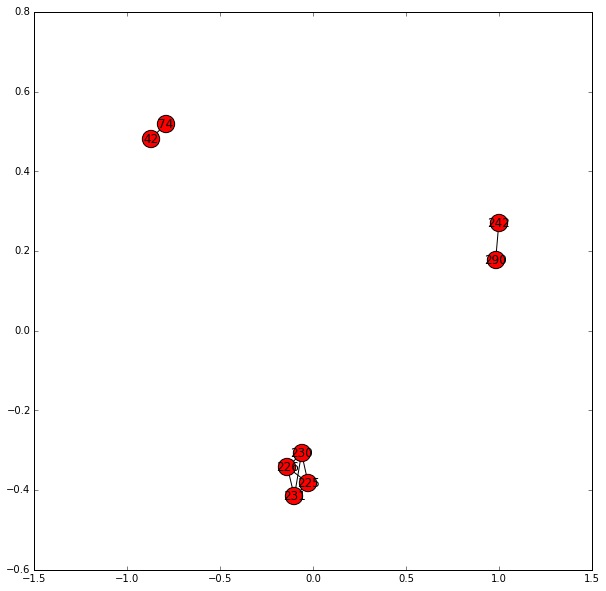

In [15]:
B3 = trim_edges(B, 17)
plt.figure(figsize = (10,10))
weights = [edata['weight'] for f,t,edata in B3.edges(data=True)]
nx.draw_networkx(B3)
B3.edges(data=True)

**Here are our 8 most connected genes in the network, each with at least 18 common substrings.**

I'm certainly no genome expert, but it is quite clear there are several distinct and highly interrelated genetic subgroups within the malaria parasite. On a very macro (re: naive) level, this genetic substructure may contribute to malaria's mutation rate and antimicrobial resistance.  
  
The author himself writes:  
  
* *Frequent genetic exchange between malaria parasites creates enormous genetic diversity that largely explains the lack of an effective vaccine for the disease.*  
  
* *Our results suggest that the structure of these sequences allows the parasite to rapidly diversify to evade immune responses while maintaining antigen structure and function.*  
  
http://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1003268